In [1]:
import cenpy
import contextily as ctx 
import segregation
%matplotlib inline
import matplotlib as mpl

In [2]:
import xyzservices.providers as xyz
import matplotlib.pyplot as plt #to make sure there are no errors when plotting a graph
from contextily import add_basemap
import folium 

In [3]:
import geopandas as gpd 
from census import Census 
from us import states
from shapely.geometry import Polygon

In [4]:
import pandas as pd

**Census Api**

In [6]:
acs=cenpy.products.ACS(year="latest")  
acs.filter_tables('HOUSEHOLDER', by='description')


,description,columns
table_name,,
B09005,HOUSEHOLD TYPE FOR CHILDREN UNDER 18 YEARS IN ...,"[B09005_001E, B09005_002E, B09005_003E, B09005..."
B09018,RELATIONSHIP TO HOUSEHOLDER FOR CHILDREN UNDER...,"[B09018_001E, B09018_002E, B09018_003E, B09018..."
B10001,GRANDCHILDREN UNDER 18 YEARS LIVING WITH A GRA...,"[B10001_001E, B10001_002E, B10001_003E, B10001..."
B10002,GRANDCHILDREN UNDER 18 YEARS LIVING WITH A GRA...,"[B10002_001E, B10002_002E, B10002_003E, B10002..."
B10010,MEDIAN FAMILY INCOME FOR FAMILIES WITH GRANDPA...,"[B10010_001E, B10010_002E, B10010_003E]"
B11010,NONFAMILY HOUSEHOLDS BY SEX OF HOUSEHOLDER BY ...,"[B11010_001E, B11010_002E, B11010_003E, B11010..."
B17009,POVERTY STATUS BY WORK EXPERIENCE OF UNRELATED...,"[B17009_001E, B17009_002E, B17009_003E, B17009..."
B17016,POVERTY STATUS IN THE PAST 12 MONTHS OF FAMILI...,"[B17016_001E, B17016_002E, B17016_003E, B17016..."
B17017,POVERTY STATUS IN THE PAST 12 MONTHS BY HOUSEH...,"[B17017_001E, B17017_002E, B17017_003E, B17017..."


In [7]:
c = Census('f5e7cf46eaa83ae8323e6051f74d9ab363d0b957')

In [9]:
# Sources: https://api.census.gov/data/2019/acs/acs5/variables.html; https://pypi.org/project/census/
bxr_householder_by_race = c.acs5.state_county_tract(fields = ('NAME', 'B25006_001E', 'B25006_002E', 'B25006_003E'),
                                      state_fips = states.TX.fips, 
                                      county_fips = "029",
                                      tract = "*",
                                      year = 2019)

In [10]:
bxr_hh_race_df = pd.DataFrame(bxr_householder_by_race)

In [11]:
print(bxr_hh_race_df.head(2))
print('Shape: ', bxr_hh_race_df.shape)

                                     NAME  B25006_001E  B25006_002E  \
0  Census Tract 1109, Bexar County, Texas       1016.0        891.0   
1  Census Tract 1110, Bexar County, Texas       1188.0        776.0   

   B25006_003E state county   tract  
0         30.0    48    029  110900  
1        103.0    48    029  111000  
Shape:  (366, 7)


access shapefile of bexar county. this will coordinate data and alignment with Mercator projection

In [12]:
bxr_census_tract = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_48_tract.zip")

print(bxr_census_tract)

     STATEFP COUNTYFP TRACTCE        GEOID     NAME              NAMELSAD  \
0         48      439  121609  48439121609  1216.09  Census Tract 1216.09   
1         48      187  210708  48187210708  2107.08  Census Tract 2107.08   
2         48      201  550301  48201550301  5503.01  Census Tract 5503.01   
3         48      201  550302  48201550302  5503.02  Census Tract 5503.02   
4         48      157  675800  48157675800     6758     Census Tract 6758   
...      ...      ...     ...          ...      ...                   ...   
5260      48      167  720501  48167720501  7205.01  Census Tract 7205.01   
5261      48      167  721202  48167721202  7212.02  Census Tract 7212.02   
5262      48      167  722002  48167722002  7220.02  Census Tract 7220.02   
5263      48      167  720301  48167720301  7203.01  Census Tract 7203.01   
5264      48      167  720503  48167720503  7205.03  Census Tract 7205.03   

      MTFCC FUNCSTAT      ALAND   AWATER     INTPTLAT      INTPTLON  \
0   

In [13]:
print(bxr_census_tract.head(2))

print('Shape: ', bxr_census_tract.shape)

# Check shapefile projection
print("\nThe shapefile projection is: {}".format(bxr_census_tract.crs))

  STATEFP COUNTYFP TRACTCE        GEOID     NAME              NAMELSAD  MTFCC  \
0      48      439  121609  48439121609  1216.09  Census Tract 1216.09  G5020   
1      48      187  210708  48187210708  2107.08  Census Tract 2107.08  G5020   

  FUNCSTAT    ALAND   AWATER     INTPTLAT      INTPTLON  \
0        S  4036421  2474977  +32.6893777  -097.2140987   
1        S  2625635        0  +29.5747421  -098.2516707   

                                            geometry  
0  POLYGON ((-97.23369 32.67175, -97.23366 32.671...  
1  POLYGON ((-98.26254 29.57872, -98.26236 29.578...  
Shape:  (5265, 13)

The shapefile projection is: epsg:4269


<AxesSubplot:>

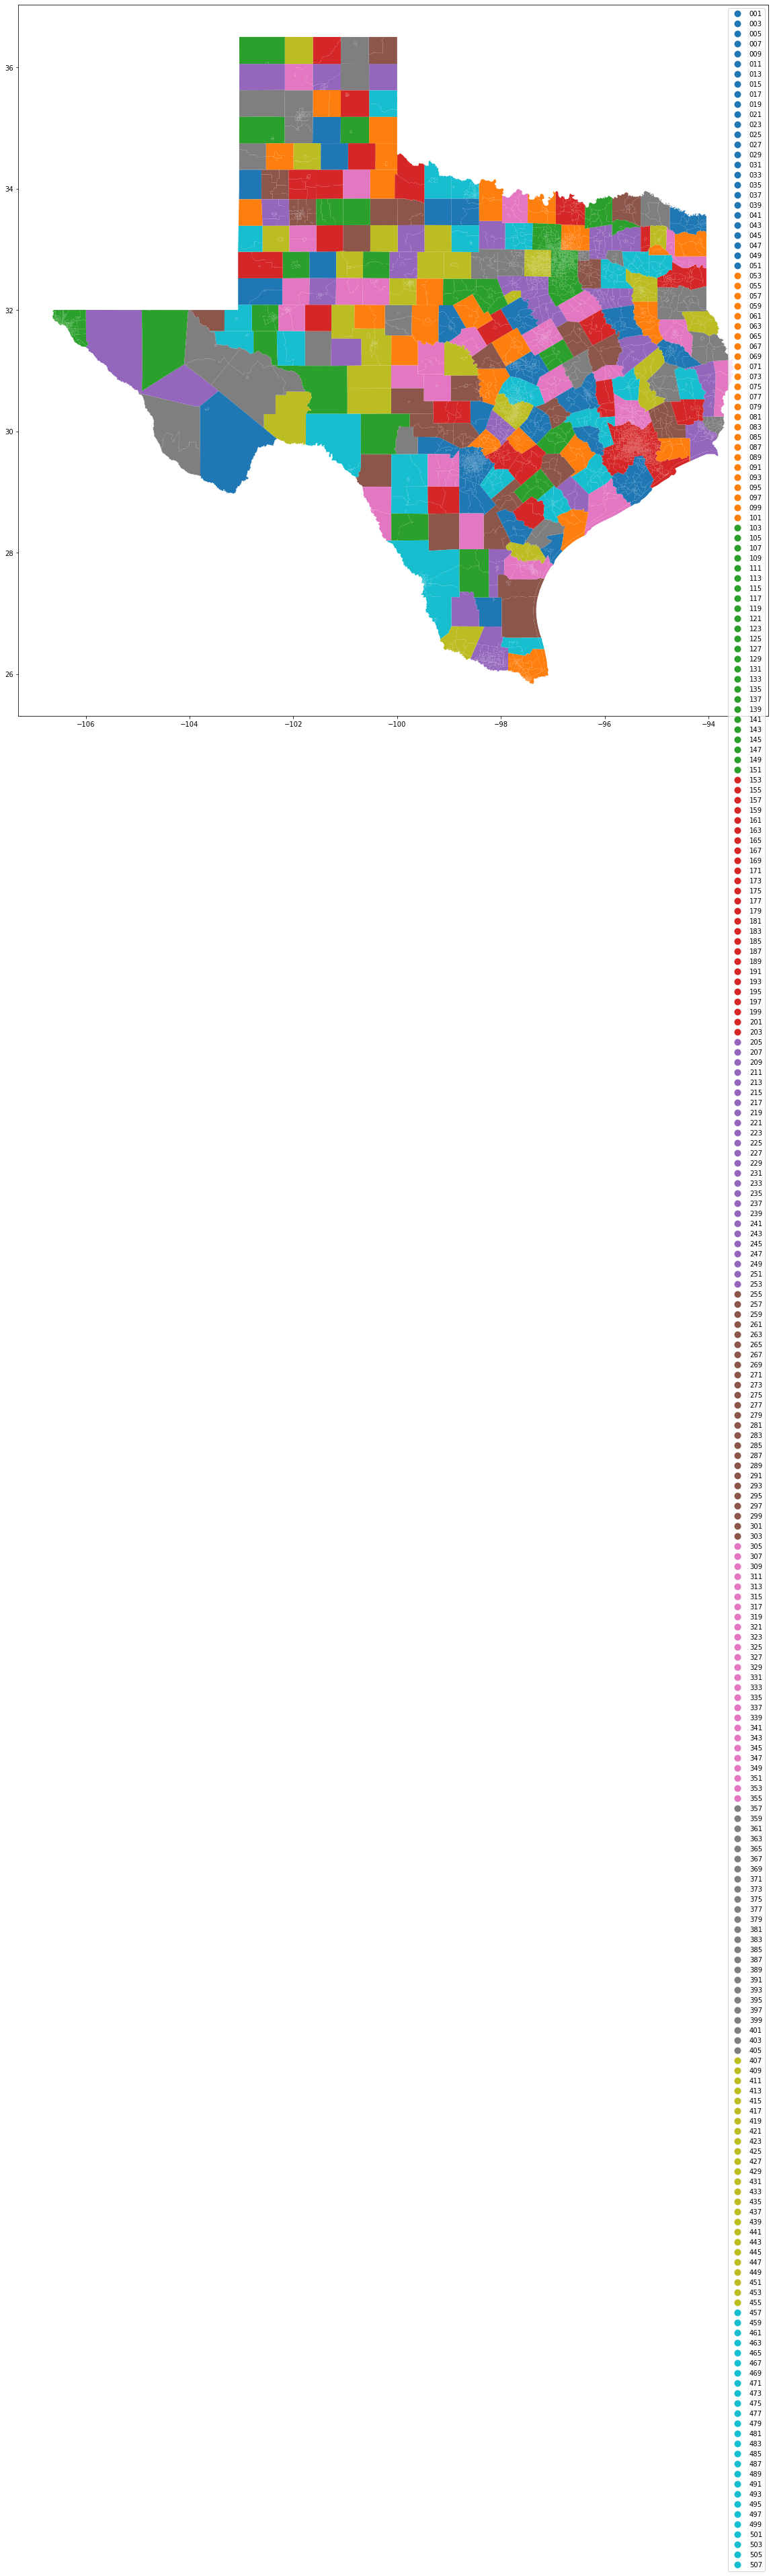

In [14]:
bxr_census_tract.plot('COUNTYFP', legend=True, figsize=(20,20))

performing dataframe operations

In [ ]:
# Combine state, county, and tract columns together to create a new string and assign to new column
bxr_df["GEOID"] = bxr_df["state"] + bxr_df["county"] + bxr_df["tract"]

In [ ]:
bxr_df.head(2)

In [ ]:
# Remove columns
bxr_df = bxr_df.drop(columns = ["state", "county", "tract"])

# Show updated dataframe
bxr_df.head(2)

In [ ]:
# Check column data types for census data
print("Column data types for census data:\n{}".format(bxr_df.dtypes))

# Check column data types for census shapefile
print("\nColumn data types for census shapefile:\n{}".format(bxr_census_tract.dtypes))

# Source: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html

In [ ]:
# Join the attributes of the dataframes together
# Source: https://geopandas.org/docs/user_guide/mergingdata.html
bxr_merge = bxr_census_tract.merge(bxr_df, on = "GEOID")

# Show result
print(bxr_merge.head(2))
print('Shape: ', bxr_merge.shape)

In [ ]:
# Create new dataframe from select columns
bxr_population_tract = bxr_merge[["STATEFP", "COUNTYFP", "TRACTCE", "GEOID", "geometry", "B02001_003E", "B02001_001E"]]

# Show dataframe
print(bxr_population_tract.head(2))
print('Shape: ', bxr_population_tract.shape)

In [ ]:
# Dissolve and group the census tracts within each county and aggregate all the values together
# Source: https://geopandas.org/docs/user_guide/aggregation_with_dissolve.html
bxr_population_county = bxr_population_tract.dissolve(by = 'COUNTYFP', aggfunc = 'sum')

# Show dataframe
print(bxr_population_county.head(2))
print('Shape: ', bxr_population_county.shape)

In [ ]:
# Get poverty rate and store values in new column
bxr_population_county["Population_Rate"] = (bxr_population_county["B02001_003E"] + bxr_population_county["B02001_001E"])/ bxr_population_county["B02001_001E"] * 100


# Show dataframe
bxr_population_county.head(2)  

In [ ]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (20, 10))

# Plot data
# Source: https://geopandas.readthedocs.io/en/latest/docs/user_guide/mapping.html
bxr_population_county.plot(column = "Population_Rate",
                       ax = ax,
                       cmap = "RdPu",
                       legend = True)

# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title('Population Rates (%) in Bexar County', fontdict = {'fontsize': '25', 'fontweight' : '3'})